In [2]:
import numpy as np
import gymnasium as gym
from gym import spaces
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

Task 1: Tabular Q-learning update

In [3]:
def init_q_table(n_states,n_actions):
    return np.zeros((n_states,n_actions))

def q_update(Q,s,a,r,s_next,alpha,gamma):
    Q[s,a]=Q[s,a]+alpha*(r+np.max(Q[s_next])-Q[s,a])
    return Q

Task 2: Epsilon Greedy policy on a custom GridWorld

In [4]:
MAPS={"4x4":["0000","0101","0001","1000"]}
class GridWorldEnvironment(gym.Env):
    metadata={"render modes":["human","rgb_array"],"render_fps": 4}
    FREE=0
    OBSTACLE=-1
    MOVES={0:(-1,0),1:(1,0),2:(0,-1),3:(0,1)}

    def parse_obstacle_map(self, obstacle_map):
        if isinstance(obstacle_map,str):
            obstacle_map=MAPS[obstacle_map]
        grid=np.array([[self.FREE if char == '0' else self.OBSTACLE for char in row]
        for row in obstacle_map])
        return grid

    def __init__(self,obstacle_map:str | list[str],render_mode:str | None=None):
        self.obstacles=self.parse_obstacle_map(obstacle_map)
        self.nrow,self.ncol=self.obstacles.shape
        self.action_space=spaces.Discrete(len(self.MOVES))
        self.observation_space=spaces.Discrete(n=self.nrow*self.ncol)
        self.terminal_states=[(0,3),(3,3)]
        self.fig=None
        self.render_mode=render_mode
        self.fps=self.metadata['render_fps']
    
    def initial_state(self):
        free_pos=np.argwhere(self.obstacles==self.FREE)
        idx=np.random.choice(len(free_pos))
        self.state=tuple(free_pos[idx])
        return self.state
    
    def traverse(self,action):
        row,col=self.state
        drow,dcol=self.MOVES[action]
        new_row, new_col = row + drow, col + dcol
        if (0<=new_row<self.nrow) and (0<=new_col<self.ncol):
            if self.obstacles[new_row,new_col]!=self.OBSTACLE:
                self.state=(new_row,new_col)
        reward=-1 
        terminated=self.state in self.terminal_states
        return self.state,reward,terminated

In [5]:
def select_action(Q,state,epsilon):
        state=(int)(state)
        if np.random.random()<epsilon:
            return np.random.choice(len(Q[state]))
        else:
            return np.argmax(Q[state])

In [6]:
reward_list=[]
def train(epsilon):
    episodes_num=500
    alpha=0.1
    gamma=0.1
    env=GridWorldEnvironment("4x4")
    Q=init_q_table(16,4)
    for ep in range(episodes_num):
        r,c=env.initial_state()
        done=0
        temp=0
        while done==0:
            idx=r*env.ncol+c
            action=select_action(Q,idx,epsilon)
            state,reward,done=env.traverse(action)
            nr,nc=state
            next_idx=nr*env.ncol+nc
            Q=q_update(Q,idx,action,reward,next_idx,alpha,gamma)
            r=nr
            c=nc
            temp+=reward
        reward_list.append(temp)
    return reward_list
eps1=train(0.01)
reward_list=[]
eps2=train(0.2)
print("Rewards for epsilon=0.1",eps1[:5])
print("Rewards for epsilon=0.2",eps2[:5])


Rewards for epsilon=0.1 [-14, -55, -18, -7, -3]
Rewards for epsilon=0.2 [-31, -14, -25, -1, -1]


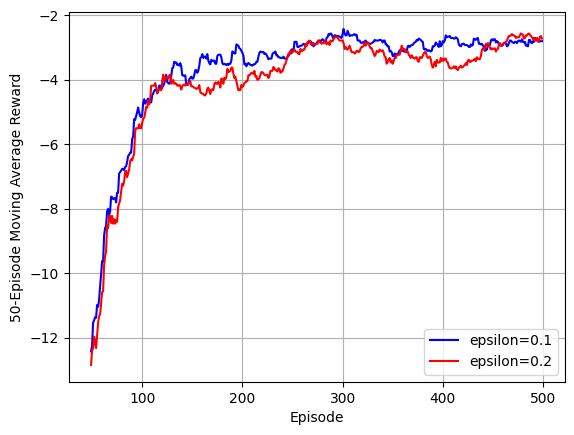

In [7]:
def moving_average(eps):
    window=50
    data=pd.Series(eps)
    move_average=data.rolling(window=window).mean()
    return move_average
moving_avgeps1=moving_average(eps1)
moving_avgeps2=moving_average(eps2)
plt.plot(moving_avgeps1,label='epsilon=0.1',color='blue')
plt.plot(moving_avgeps2,label='epsilon=0.2',color='red')
plt.xlabel("Episode")
plt.ylabel("50-Episode Moving Average Reward")
plt.legend()
plt.grid(True)
plt.show()

The above plot indicates that the 50 episode moving average trend for epsilon value=0.1 is higher compared to epsilon value=0.2. This tells us that the small epsilon value allows more exploitation instead of exploration which means that the rewards are maximized. The high value of epsilon reflects more exploration and randomness as observed in the red plot.

Task 3: Experience Replay Buffer

In [8]:
class ReplayBuffer:

    def __init__(self,capacity):
        self.buffer=deque(maxlen=capacity) 

    def push(self,state,action,reward,next_state,done):
        self.buffer.append((state,action,reward,next_state,done))

    def sample(self,batch_size):
        batch=random.sample(self.buffer,batch_size)
        state,action,reward,next_state,done=zip(*batch)
        state=np.array(state)
        action=np.array(action)
        reward=np.array(reward)      
        next_state=np.array(next_state)
        done=np.array(done)
        return state,action,reward,next_state,done
    
buffer=ReplayBuffer(capacity=100)
for i in range(100):
    buffer.push(np.random.randint(0,16),np.random.randint(0,4),np.random.uniform(-1,1),np.random.randint(0,16),np.random.choice([True, False]))
state,action,reward,next_state,done=buffer.sample(32)
print("Shapes and Data Types:")
print("States:",state.shape,"\t",state.dtype)
print("Actions:",action.shape,"\t",action.dtype)
print("Rewards:",reward.shape,"\t",reward.dtype)
print("Next States:",next_state.shape,"\t",next_state.dtype)
print("Dones:",done.shape,"\t",done.dtype)

        

Shapes and Data Types:
States: (32,) 	 int64
Actions: (32,) 	 int64
Rewards: (32,) 	 float64
Next States: (32,) 	 int64
Dones: (32,) 	 bool


Task 4: Deep Q Network with Target Copy
Defining two neural network models.

In [9]:
class DQNPolicy(nn.Module):
    def __init__(self,n_states,n_actions):
        super(DQNPolicy,self).__init__()
        self.hl1=nn.Linear(n_states,128)
        self.hl2=nn.Linear(128,128)
        self.hl3=nn.Linear(128,n_actions)

    def forward(self,x):
        x=F.relu(self.hl1(x))
        x=F.relu(self.hl2(x))
        return self.hl3(x)

class DQNTarget(nn.Module):
    def __init__(self,n_states,n_actions):
        super(DQNTarget,self).__init__()
        self.hl1=nn.Linear(n_states,128)
        self.hl2=nn.Linear(128,128)
        self.hl3=nn.Linear(128,n_actions)
    
    def forward(self,x):
        x=F.relu(self.hl1(x))
        x=F.relu(self.hl2(x))
        return self.hl3(x)

def update_target(policy_net,target_net):
    target_net.load_state_dict(policy_net.state_dict())

Task 5: Full DQN Training Loop on CartPole-v1

The number of episodes is 5000 to ensure that the model gets trained effectively and has stability. For a simple CartPole enevironment usually less than 1000 episodes are enough to maximize rewards but I tried several values like 1500,2000,3000 and 5000. After observing the moving average plots maximum rewards are collected for number of episodes ranging between 1000 and 3000. So finally I kept the number of episodes as 1500. For more number of episodes more than 1500 the run time is almost an hour. 
First I kept the value of gamma 0.1 but the model did not give the desired results and even the success rate was very low. Then I changed it to different values like 0.2,0.4,0.7 and 0.9. For the value of gamma equal to 0.9, I got better results compared to the previous ones. 
The decay rate of epsilon is 500 to ensure that over 3000 episodes a stable decay of epsilon takes place and the process of exploration and exploitation is smooth.
To ensure fast training and less run time I kept the capacity of the Replay Buffer equal to 5000.
Initially I was confused with the values of batch size. 32 would be too low and the gradients would be noisy. 100 means more memory storage. 64 was an intermediate and stable value.


In [ ]:
#defining an environment
env=gym.make("CartPole-v1")
#to determine the number of actions possible for an agent in the environment 
n_actions=env.action_space.n
state,info=env.reset()
n_states=len(state)
policy_net=DQNPolicy(n_states,n_actions)
target_net=DQNTarget(n_states,n_actions)
update_target(policy_net,target_net)
buffer=ReplayBuffer(10000)
optimizer=optim.Adam(policy_net.parameters(),lr=1e-3)
loss=nn.MSELoss()
#total number of episodes
N=1500
X=100
eps_max=1
eps_min=0.01
#epsilon decay rate
M=1000
gamma=0.9
#batch size on which gradient descent is performed 
batch_size=64
episode_rewards=[]
for ep in range(N):
    #values of epsilon decaying after each episode
    epsilon=max(eps_min,eps_max-ep/M)
    #bringing the agent back to an initial state
    state,info=env.reset()
    done=False
    total_reward=0
    while not done:
        #selecting the action based on epsilon greedy policy
        if random.random()<epsilon:
            action=env.action_space.sample()
        else:
            state_tensor=torch.tensor(state,dtype=torch.float32).view(1,-1)
            q_value=policy_net(state_tensor)
            #finding the maximum reward for an action and returning its index value
            action=q_value.argmax(dim=1).item()
        state_next,reward,terminated,truncated,info=env.step(action)
        done=terminated or truncated
        #pushing different transitions into a queue to train the model
        buffer.push(state,action,reward,state_next,done)
        state=state_next
        total_reward=total_reward+reward
        if len(buffer.buffer)>=batch_size:
            states,actions,rewards,next_states,dones=buffer.sample(batch_size)
            #converting the ndim arrays to tensors to feed into the model
            #reshaping the tensors accordingly to feed into the model
            states=torch.tensor(states,dtype=torch.float32)
            actions=torch.tensor(actions,dtype=torch.int64).view(-1,1)
            next_states=torch.tensor(next_states,dtype=torch.float32)
            dones=torch.tensor(dones,dtype=torch.int64).view(-1,1)
            rewards=torch.tensor(rewards,dtype=torch.float32).view(-1,1)
            q_values=policy_net(states).gather(1,actions)
            next_q_values=target_net(next_states).max(dim=1)[0].view(-1,1)
            #multiplied with (1-dones) to ensure that if the episode is terminated then future q values are not calculated 
            targets=rewards+gamma*next_q_values*(1-dones)
            total_loss=loss(q_values,targets)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

    if ep%300==0:
        print("For Episode:",ep)
        print("Total Loss:",total_loss.item())
        print("Total Rewards:",total_reward)
        print("Current Epsilon:",epsilon)
        print("\n")

    episode_rewards.append(total_reward)
    #ensuring a temporary target network for the model
    if ep%X==0:
        update_target(policy_net,target_net)



For Episode: 0
Total Loss: 0.052270688116550446
Total Rewards: 15.0
Current Epsilon: 1.0



For Episode: 300
Total Loss: 0.017680330201983452
Total Rewards: 18.0
Current Epsilon: 0.7



For Episode: 600
Total Loss: 0.021901659667491913
Total Rewards: 13.0
Current Epsilon: 0.4



For Episode: 900
Total Loss: 0.0055704014375805855
Total Rewards: 123.0
Current Epsilon: 0.09999999999999998



For Episode: 1200
Total Loss: 0.007667990401387215
Total Rewards: 230.0
Current Epsilon: 0.01





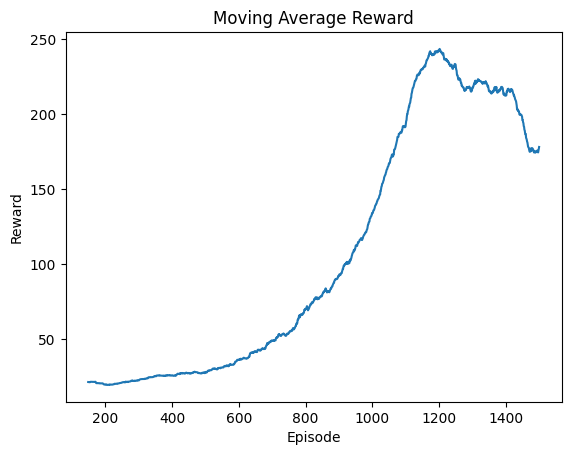

In [13]:
#calculating the moving average over a window of 10 elements
window=int(N/10)
data=pd.Series(episode_rewards)
moving_avg=data.rolling(window=window).mean()
plt.plot(moving_avg)
plt.title("Moving Average Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [14]:
#calculating the success rate of the model
count=0
for i in episode_rewards:
    if(i>=195):
        count=count+1
print(f"Percentage ={count/len(episode_rewards)*100}")

Percentage =18.266666666666666
